In [1]:
import sys
sys.path.append('..')

import attack
import data_loader as dl
import pandas as pd
import numpy as np
import time
import datetime

In [2]:
# Load preprocessed data 
raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf = dl.load_geolife(
    data_type='raw', 
    min_n_trips_per_user=5,
    tessellation_diameter=300)
assert len(raw_full_trip_gdf) == len(raw_trip_sp_gdf) == len(raw_trip_ep_gdf)

Reading splitted geolife geojson file...
Done.
Number of trajectories in loaded dataset: 26643
Number of users in loaded dataset: 160


In [3]:
gdf_sp, gdf_ep = attack.match_boundary_points_with_tessellation(raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf)

In [4]:
full_trip_gdf, trip_sp_gdf, trip_ep_gdf, gdf_sp, gdf_ep = attack.extract_trips_that_start_end_in_tessellation(raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, gdf_sp, gdf_ep)


Number of trips that start and end wihin tessellation area: 23077
Number of trips outside and therefore dropped: 3566


Max nr of points: 16213
95% quantile of nr of points: 2040.4000000000015
5% quantile of nr of points: 48.0


<Axes: ylabel='Frequency'>

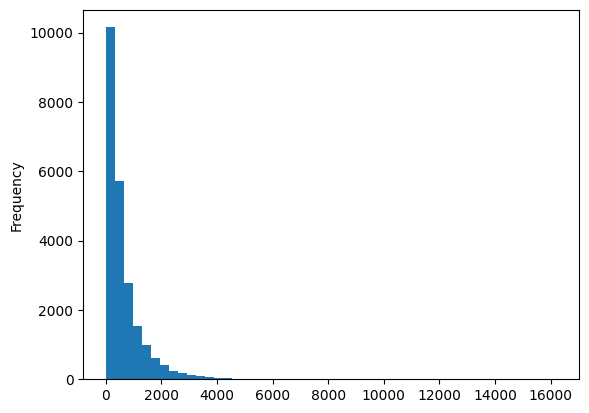

In [7]:
print(f'Max nr of points: {full_trip_gdf.geometry.apply(lambda x: len(x.coords)).max()}')
print(f'95% quantile of nr of points: {full_trip_gdf.geometry.apply(lambda x: len(x.coords)).quantile(0.95)}')
print(f'5% quantile of nr of points: {full_trip_gdf.geometry.apply(lambda x: len(x.coords)).quantile(0.05)}')
full_trip_gdf.geometry.apply(lambda x: len(x.coords)).plot.hist(bins=50)

In [ ]:
full_trip_gdf = full_trip_gdf[['TRIP_ID', 'TRIP_START', 'PERSON_ID', 'geometry']].copy()

In [20]:
full_trip_gdf['TRIP_START'] = pd.to_datetime(full_trip_gdf['TRIP_START'], format='%Y-%m-%d %H:%M:%S')

In [33]:
# Convert to UNIX timestamp
full_trip_gdf['TIMESTAMP'] = full_trip_gdf.TRIP_START.apply(lambda x: int(datetime.datetime.timestamp(x)))

In [34]:
full_trip_gdf = full_trip_gdf.drop('TRIP_START', axis=1)

In [35]:
full_trip_gdf = full_trip_gdf.rename(columns={'geometry': 'POLYLINE'})

In [36]:
full_trip_gdf['POLYLINE'] = full_trip_gdf.POLYLINE.to_crs(4326)

In [37]:
full_trip_gdf['POLYLINE'] = full_trip_gdf.POLYLINE.apply(lambda x: [l for l in [list(c) for c in x.coords]])

In [38]:
full_trip_gdf['MISSING_DATA'] = False

In [41]:
full_trip_gdf = full_trip_gdf.reset_index(drop=True)

In [43]:
full_trip_gdf.to_csv('../data/geolife/geolife.csv', index=False)